# APOGEE Stellar Spectra
In this notebook, we explore Bayesian linear regression using APOGEE stellar spectra data. We'll learn how to:

- Properly quantify prediction uncertainties
- Understand why naive MLE error estimates fail
- Implement Bayesian linear regression with heteroscedastic noise
- Make predictions with full uncertainty quantification
- Evaluate model calibration using coverage statistics

## Setup and Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plotting parameters
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

## Loading and Preparing Dataset

### Background
APOGEE (Apache Point Observatory Galactic Evolution Experiment) provides high-resolution infrared spectra of stars. Each spectrum contains flux measurements at different wavelengths that encode information about stellar properties including temperature.

### Load Data and Add Heteroscedastic Noise

Load the dataset and add realistic heteroscedastic noise to temperatures:

$$\sigma_{\text{teff}} = 50 + 150 \cdot \frac{T_{\text{eff}} - T_{\text{min}}}{T_{\text{max}} - T_{\text{min}}}$$

This creates uncertainties ranging from 50K (coolest stars) to 200K (hottest stars).

In [35]:
np.random.seed(42)

# Load 'dataset_apogee_spectra.npz' and extract arrays
file = np.load('dataset_apogee_spectra.npz')
spectra = file['spectrum_array']
wavelength = file['wavelength']
teff_array = file['teff_array']

# Calculate teff_min, teff_max from teff_array
teff_min = teff_array.min()
teff_max = teff_array.max()

# Calculate sigma_teff using formula: 50 + 150 * (teff - min)/(max - min)
sigma_teff = 50 + 150 * (teff_array - teff_min) / (teff_max - teff_min)

# Create teff_observed = teff_array + np.random.normal(0, sigma_teff)
teff_observed = teff_array + np.random.normal(0, sigma_teff)

# Print summary statistics
print(f"Teff Observed: min={teff_observed.min():.2f}, max={teff_observed.max():.2f}, mean={teff_observed.mean():.2f}, std={teff_observed.std():.2f}")
print(f"Total stars: {len(teff_observed)}")

Teff Observed: min=3150.64, max=7349.62, mean=4404.49, std=713.96
Total stars: 3000


### Construct Design Matrix

Create design matrix $\boldsymbol{\Phi}$ with:
- Each row = one star (N stars)
- Each column = one spectral feature (M wavelengths)
- Add bias term (column of ones) at the end

The final dimension of the design matrix should be 3000 x 2001

In [36]:
# Construct design matrix Phi
phi = np.hstack((spectra, np.ones((len(spectra), 1))))

# Print shape of design matrix
print(f"Phi shape: {phi.shape}")

Phi shape: (3000, 2001)


### Train-Test Split

Split data into 80% training and 20% testing, including uncertainties.

In [37]:
# 80-20 train-test split
n_train = int(0.8 * len(phi))

# Generate random permutation of indices
indices = np.random.permutation(len(phi))

# Split using indices[:n_train] and indices[n_train:]
train = indices[:n_train]
test = indices[n_train:]

# Create Phi_train, Phi_test, t_train, t_test, sigma_train, sigma_test
Phi_train = phi[train]
Phi_test = phi[test]

t_train = teff_observed[train]
t_test = teff_observed[test]

sigma_train = sigma_teff[train]
sigma_test = sigma_teff[test]

### Visualize Spectra

Plot all spectra color-coded by temperature with a colorbar.

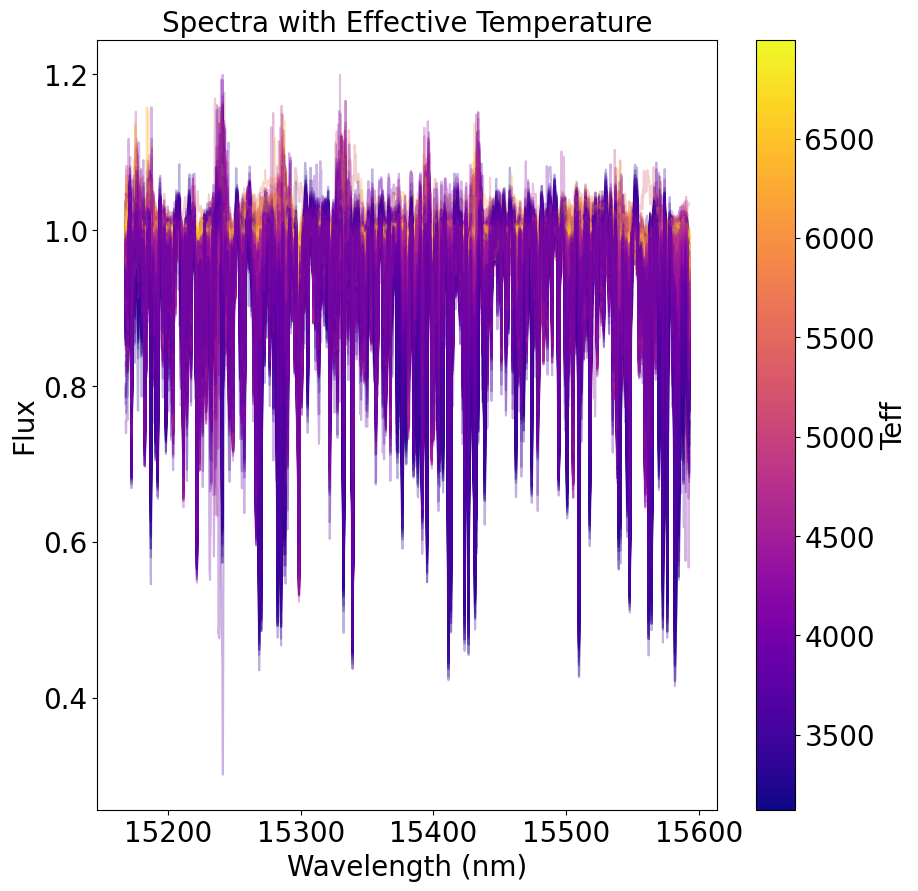

In [38]:
fig, ax = plt.subplots()
colors = plt.cm.plasma((teff_array - teff_min) / (teff_max - teff_min))

# Loop: ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.3)
for i in range(len(spectra)):
    ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.3)

# Add colorbar with ScalarMappable
colorbar = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=teff_min, vmax=teff_max))
fig.colorbar(colorbar, label="Teff", ax=ax)

# Set labels and show
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux")
ax.set_title("Spectra with Effective Temperature");

## MLE Error Estimates

### Background
The maximum likelihood solution for linear regression is:

$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

### Compute MLE and Naive Uncertainty Estimates

Implement the MLE solution and compute RMSE on training and test sets:

$$\sigma_{\text{naive}} = \sqrt{\frac{1}{N}\sum_{n=1}^N(t_n - \mathbf{w}_{\text{ML}}^T\boldsymbol{\phi}_n)^2}$$

In [39]:
# Define function to fit naive MLE and compute RMSE and uncertainty
def fit_naive_mle(Phi_train, t_train, Phi_test, t_test):
    w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
    
    # Define predictions
    pred_train = Phi_train @ w_ml
    pred_test = Phi_test @ w_ml
    
    # Uncertainty estimates
    sigma_mle = np.sqrt(np.mean((t_train - pred_train) ** 2))
    
    # RMSE on test set
    rmse_test = np.sqrt(np.mean((t_test - pred_test) ** 2))
    
    return rmse_test, sigma_mle

# Call function and print ratio rmse_test/sigma_mle
rmse_test, sigma_mle = fit_naive_mle(Phi_train, t_train, Phi_test, t_test)
print(f"RMSE/Sigma_mle ratio: {rmse_test / sigma_mle:.2f}")

RMSE/Sigma_mle ratio: 9.44


### Visualize Residuals

Create two plots:
1. Histogram of training vs test residuals with Gaussian fits
2. Histogram of normalized test residuals compared to N(0,1)

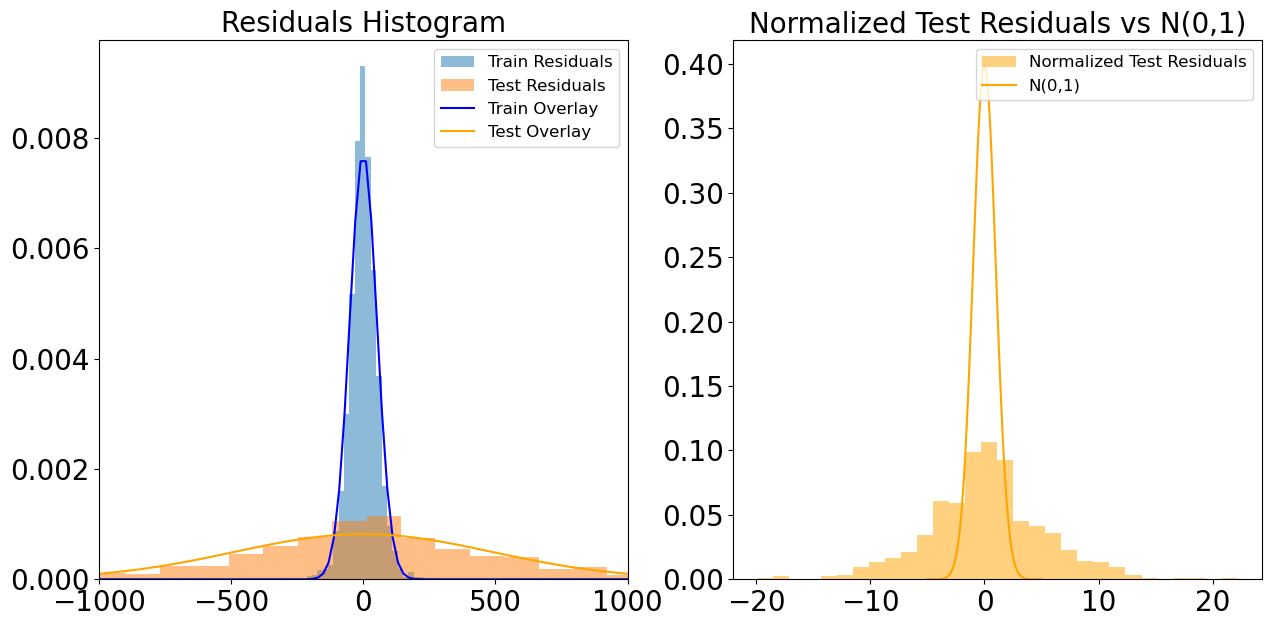

In [40]:
# Create 2 subplots (1,2)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Left: histogram of residuals_train and residuals_test with Gaussian overlays
ax[0].hist(t_train - (Phi_train @ np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train), bins=30, alpha=0.5, label='Train Residuals', density=True)
ax[0].hist(t_test - (Phi_test @ np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train), bins=30, alpha=0.5, label='Test Residuals', density=True)

x = np.linspace(-1000, 1000, 100)
ax[0].plot(x, (1/(sigma_mle * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / sigma_mle)**2), color='blue', label='Train Overlay')
ax[0].plot(x, (1/(rmse_test * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / rmse_test)**2), color='orange', label='Test Overlay')

ax[0].set_xlim(-1000, 1000)
ax[0].set_title("Residuals Histogram")
ax[0].legend(fontsize=12)

# Right: histogram of (residuals_test / sigma_test) vs N(0,1)
ax[1].hist((t_test - (Phi_test @ np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train)) / sigma_test, bins=30, alpha=0.5, label='Normalized Test Residuals', density=True, color='orange')

# Overlay N(0,1)
x = np.linspace(-5, 5, 100)
ax[1].plot(x, (1/np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2), color='orange', label='N(0,1)')
ax[1].set_title("Normalized Test Residuals vs N(0,1)")
ax[1].legend(fontsize=12, loc='upper right');

It seems to be overestimating the uncertainty. It may be wider wider since it didnt accurately account for variance.

## Bayesian Linear Regression

### Background
Bayesian linear regression computes a posterior distribution:

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$$

where:
- $\mathbf{S}_N = (\mathbf{S}_0^{-1} + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$ (posterior covariance)
- $\mathbf{m}_N = \mathbf{S}_N(\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t})$ (posterior mean)
- $\mathbf{S}_0 = \eta^2\mathbf{I}$ (prior covariance)
- $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, ..., \sigma_N^2)$ (measurement covariance)

### Compute Posterior Distribution

Implement the posterior computation for different prior strengths $\eta^2$ = [1000, 100000, 10000000].

In [41]:
# Define function to compute posterior distribution
def compute_posterior(Phi, t, sigma, eta2):
    M = Phi.shape[1]

    # Inverse prior covariance S0_inv
    S0_inv = np.eye(M) / eta2

    # Inverse noise covariance Sigma_inv
    Sigma_inv = np.diag(1 / sigma**2)

    # Posterior covariance S_N
    S_N = np.linalg.inv(S0_inv + Phi.T @ Sigma_inv @ Phi)

    # Posterior mean m_N
    m_N = S_N @ (Phi.T @ Sigma_inv @ t)

    return m_N, S_N


# Loop eta2_values=[1e3, 1e5, 1e7], compute posteriors
eta2_values = [1e3, 1e5, 1e7]
posteriors = []
for eta2 in eta2_values:
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    posteriors.append((m_N, S_N))

Here the best weights correspond to the mean and variance of the data

### Visualize Spectral Weights

Plot the spectral weights with uncertainty bands (±2σ) for each prior strength.

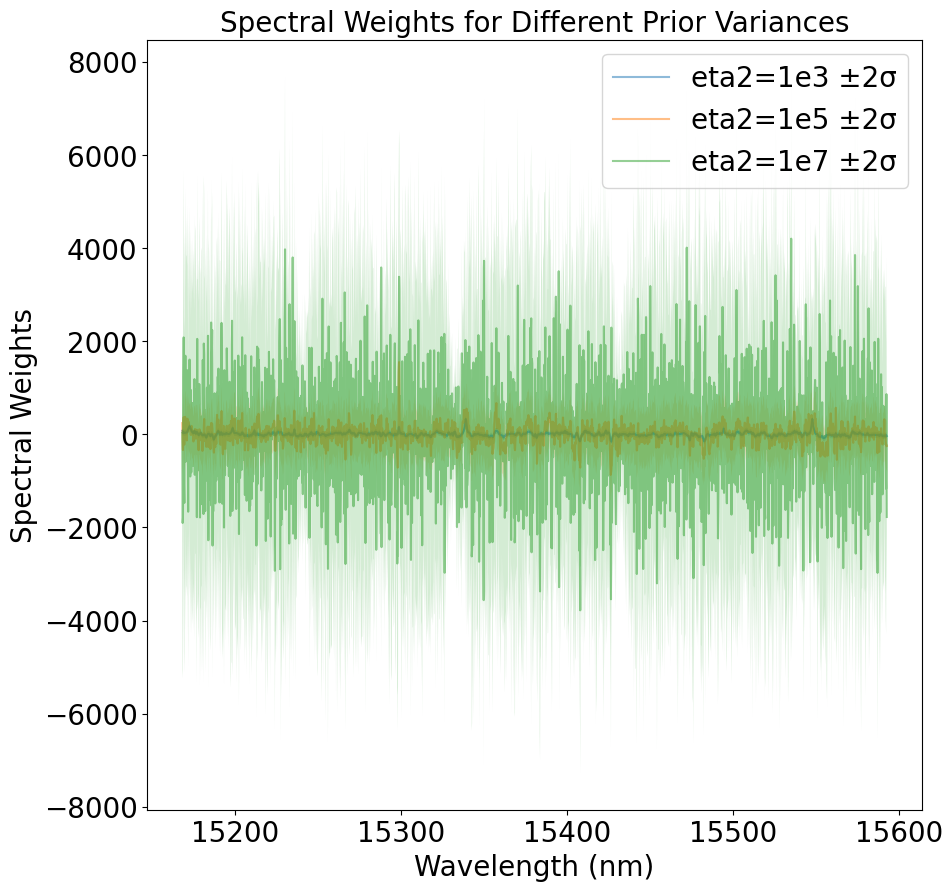

In [42]:
# Loop posteriors: 
spectral_weights = []
weight_stds = []

for m_N, S_N in posteriors:
    # spectral_weights = m_N[:-1]
    spectral_weights.append(m_N[:-1])

    # weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))
    weight_stds.append(np.sqrt(np.diag(S_N[:-1, :-1])))

# Plot spectral_weights vs wavelength for each eta2
plt.plot(wavelength, spectral_weights[0], label='eta2=1e3 ±2σ', alpha=0.5)
plt.plot(wavelength, spectral_weights[1], label='eta2=1e5 ±2σ', alpha=0.5)
plt.plot(wavelength, spectral_weights[2], label='eta2=1e7 ±2σ', alpha=0.5)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Weights")
plt.title("Spectral Weights for Different Prior Variances")
plt.legend()

# plt.fill_between(wavelength, weights-2*std, weights+2*std, alpha=0.2)
plt.fill_between(wavelength, spectral_weights[0]-2*weight_stds[0], spectral_weights[0]+2*weight_stds[0], alpha=0.2)
plt.fill_between(wavelength, spectral_weights[1]-2*weight_stds[1], spectral_weights[1]+2*weight_stds[1], alpha=0.2)
plt.fill_between(wavelength, spectral_weights[2]-2*weight_stds[2], spectral_weights[2]+2*weight_stds[2], alpha=0.2);

The value for $\eta^2$ = 1e5 could have more accurate weights since it's closer to the scale of the data prior to normalization.

## Making Bayesian Predictions with Uncertainty

### Background
The predictive distribution is:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \mathcal{N}(t_*|\mu_*, \sigma_*^2)$$

with:
- Mean: $\mu_* = \mathbf{m}_N^T\boldsymbol{\phi}_*$
- Variance: $\sigma_*^2 = \sigma_{\text{obs},*}^2 + \boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_* + \sigma_{\text{model}}^2$

### Implement Prediction Function

In [43]:
# Define function to predict with uncertainty
def predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model):

    # Predictive mean
    pred_mean = Phi_new @ m_N

    # Parameter variance
    param_var = np.sum(Phi_new @ S_N * Phi_new, axis=1)

    # Predictive variance
    pred_var = param_var + sigma_new**2 + sigma_model**2

    # Return the predictions and uncertainties
    return pred_mean, np.sqrt(pred_var)

### Visualize Predictions with Uncertainties

Plot predicted vs true temperatures with uncertainty bands.

RMSE for η²=1e+03: 294.82
RMSE for η²=1e+05: 166.42
RMSE for η²=1e+07: 220.42


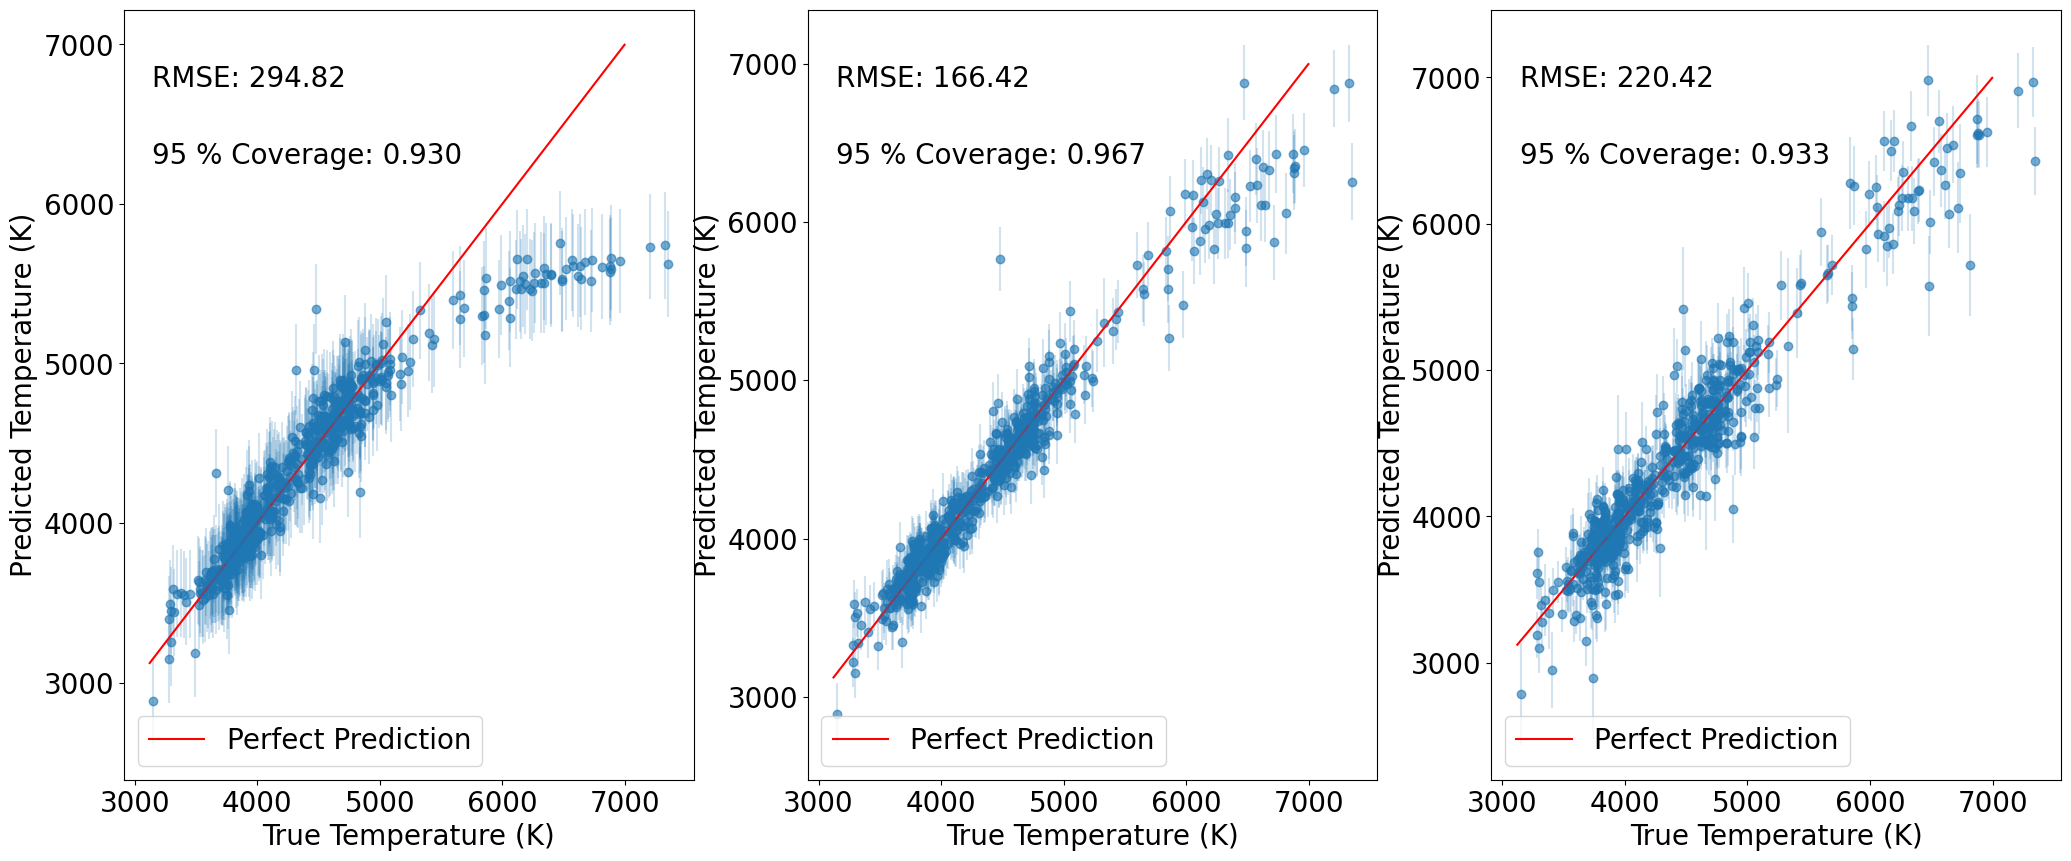

In [44]:
# Loop posteriors, get pred_mean and pred_std
fig, ax = plt.subplots(1, 3, figsize=(25, 10))

for i, (m_N, S_N) in enumerate(posteriors):
    eta2 = eta2_values[i]

    sigma_model = np.sqrt(np.mean((t_train - (Phi_train @ m_N))**2))
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N, S_N, sigma_model)

    # plt.scatter(t_test, pred_mean), add y=x line
    ax[i].scatter(t_test, pred_mean, alpha=0.5)
    ax[i].errorbar(t_test, pred_mean, yerr=pred_std, fmt='o', alpha=0.2)

    x = np.linspace(teff_min, teff_max, 100)
    ax[i].plot(x, x, color='red', label='Perfect Prediction')

    ax[i].set_xlabel("True Temperature (K)")
    ax[i].set_ylabel("Predicted Temperature (K)")
    ax[i].legend()

    # rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    print(f"RMSE for η²={eta2:.0e}: {rmse:.2f}")
    ax[i].text(0.05, 0.9, f'RMSE: {rmse:.2f}', transform=ax[i].transAxes, fontsize=20)

    # z_scores = (t_test - pred_mean) / pred_std
    z_scores = (t_test - pred_mean) / pred_std

    # coverage = np.mean(np.abs(z_scores) < 2)
    coverage = np.mean(np.abs(z_scores) < 2)
    ax[i].text(0.05, 0.8, f'95 % Coverage: {coverage:.3f}', transform=ax[i].transAxes, fontsize=20)

### Calculate Coverage

Compute the 95% coverage using Z-scores:

$$z = \frac{t_{\text{true}} - t_{\text{predicted}}}{\sigma_{\text{predicted}}}$$

For well-calibrated uncertainties, ~95% of z-scores should have |z| < 2.

In [45]:
# Loop posteriors
for i, (m_N, S_N) in enumerate(posteriors):
    eta2 = eta2_values[i]

    # Get predictions
    sigma_model = np.sqrt(np.mean((t_train - (Phi_train @ m_N))**2))
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N, S_N, sigma_model)

    # Calculate rmse, z_scores, coverage
    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    z_scores = (t_test - pred_mean) / pred_std
    coverage = np.mean(np.abs(z_scores) < 2)

    print(f"η²={eta2:.0e}: RMSE={rmse:.1f} K, Coverage={coverage:.3f}")

η²=1e+03: RMSE=294.8 K, Coverage=0.930
η²=1e+05: RMSE=166.4 K, Coverage=0.967
η²=1e+07: RMSE=220.4 K, Coverage=0.933


**Results:**
* $\eta^2$ = 1e5 gives the best coverage

**Note***
* Coverage < 0.95 indicates the model is overconfident since it has a narrower confidence interval.
* Coverage > 0.95 indicates the model is underconfident since it has a wider confidence interval.

## **Key Takeaways:**

1. **Naive MLE fails:** Training RMSE severely underestimates prediction uncertainty due to overfitting

2. **Bayesian approach:** Properly accounts for parameter uncertainty, measurement noise, and model inadequacy

3. **Prior selection:** The prior strength $\eta^2$ controls the balance between flexibility and regularization

4. **Calibration matters:** Well-calibrated uncertainties are essential for scientific inference

5. **Uncertainty decomposition:** Understanding different sources of error helps guide improvement efforts

6. $\eta^2$ = 1e5 was the most optimal with RMSE = 166.4 K and coverage = .967.